# Classificando notícias com RNN

Temos desafio de organizar notícias, de acordo com o tema, contexto, sentimento.

"Pela quarta rodada do Campeonato Italiano, a Roma não tomou conhecimento do Empoli neste domingo e venceu pela primeira vez na competição."

Com base nesse contexto, poderiamos classificar essa notícia como do tipo "Esportes", certo? E por que sabemos disso? Bem, podemos observar algumas palavrinhas chaves tal como "campeonato" e "competição".

Vamos usar RNNs para realizar esta tarefa, analisar notícias e classificá-las com base em palavras-chaves. 

**Redes Neuras Recorrentes** têm a capacidade de aprender não só com os dados de entrada, mas com seus próprios outputs, ou seja, ocorre um loop de aprendizado.

# Importando bibliotecas

In [ ]:
!pip install nltk
!pip install wordcloud

In [6]:
# Básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para NLP
import re, nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Jackson
[nltk_data]     Simionato\AppData\Roaming\nltk_data...


True

# Lendo e explorando dados

In [9]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/5b00193e34c5955ba16b315efe415119fdce3bce/Aula%204%20-%20Redes%20Neurais%20Recorrentes/bbc-text.csv')

In [10]:
# DF com label e texto
df= raw_df.copy()
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [11]:
# Categorias presentes no DF. Problema de multiclasse.
df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [12]:
# Não há dados faltantes
df.isna().sum()

category    0
text        0
dtype: int64

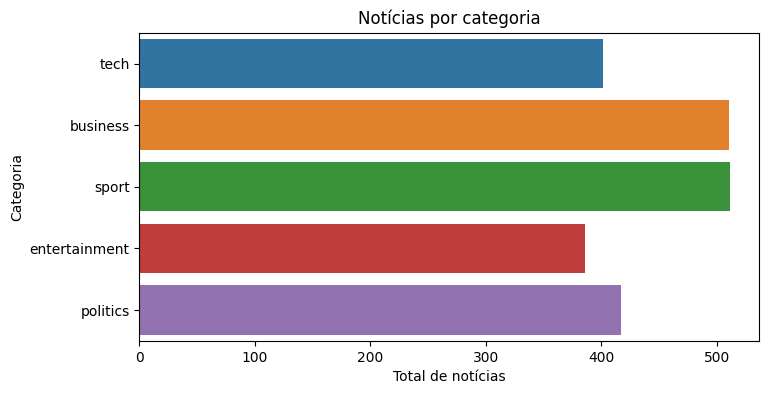

In [24]:
# Plot de notícias por categoria. Não há desequilíbrio entre as classes
fig, ax = plt.subplots(figsize=(8, 4))

sns.countplot(df, y='category', hue='category',ax=ax)

ax.set_xlabel('Total de notícias')
ax.set_ylabel('Categoria')
ax.set_title('Notícias por categoria')

plt.show()

# Pré-processamento de texto

Há uma grande diferença entre modelos que trabalham com texto e os modelos de ML convencionais. Um ML padrão possui dados numéricos bem estruturados em colunas e linhas. 

Já ao trabalhar com textos, as próprias palavras devem ser tratadas como variáveis ou propriedades do dado. Para simular isso, processos como a **tokenização**, o One-Hot encoding, o Pad sequencing e a camada Embedding Layer são utilizados

- Tokenization (separar o texto em "tokens", ou seja, separar parte por parte).
- One-Hot encoding (representar variáveis categóricas como vetores binários).
- Pad sequencing (Garante sequências de comprimento uniforme adicionando zeros nas sequencias de palavas para manter sequencias uniformes)
- Embedding layer (Word2Vec) (mapear palavras em vetores)

## Limpeza

Como primeiro passo, é necessário aplicar tecnicas para limpar e padronizar o texto, aplicando REGEX, removendo stop words e lematização (unificar palavras conjugadas de maneira diferente). 

### REGEX

FOrma flexível de identificar uma determinada sequencia de caracteres. Uma cadeia pode ser um caractere específico, uma palavra ou um padrão. No Python, o módulo re provê um analisador sintático que permite o uso de tais expressões. Os padrões definidos através de caracteres que tem significado especial para o analisador.

### Stop words

Busca descartar palavras como artigos e conjunções que não trazem significado para o texto. Ex: 'the', 'is', 'a'

### Lematização

Basicamente é um processo que determina uma única “raiz” para a palavra, independente de suas diferenças superficiais.

In [66]:
def limpeza_texto(text):
    # REGEX
    whitespace = re.compile(r"\s+") # Identifica espaços em branco
    user_mention = re.compile(r"(?i)@[a-z0-9_]+") # Identifica menções a usuarios com @
    text = whitespace.sub(' ', text) # Remove espaços em branco
    text = user_mention.sub('',text) # Remove menções a usuarios
    text = re.sub(r"\[[^()]*\]","", text)                      # remove o conteúdo dentro de colchetes, incluindo os colchetes
    text = re.sub("\d+", "", text)  # Remove digitos numéricos
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)","", text) # Remove menções de usário, urls, hashtags
    text = re.sub("[^\w\s]", "", text) # Remove caracteres que não palavras, caracteres especiais
    text = text.lower() # Converte para minúsculo


    return print(text)

In [67]:
limpeza_texto('aaaqqq [{12@}] 12asxaqw qwqwa ab http@ #partiu &&  ADEUSss')

aaaqqq  asxaqw qwqwa ab http   adeusss
